In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import sys
plt.style.use('dark_background')
# change the police in plots to SERIF
plt.rcParams['font.family'] = 'serif'

# Add the parent directory to sys.path to import local modules
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
	sys.path.append(module_path)

from streamingModels.streamingModels import PARegressor
import matplotlib.pyplot as plt
from river import metrics
from river import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Processed 0 instances...
Processed 100 instances...
Processed 200 instances...
Processed 300 instances...
Processed 400 instances...
Processed 500 instances...
Processed 600 instances...
Processed 700 instances...
Processed 800 instances...
Processed 900 instances...


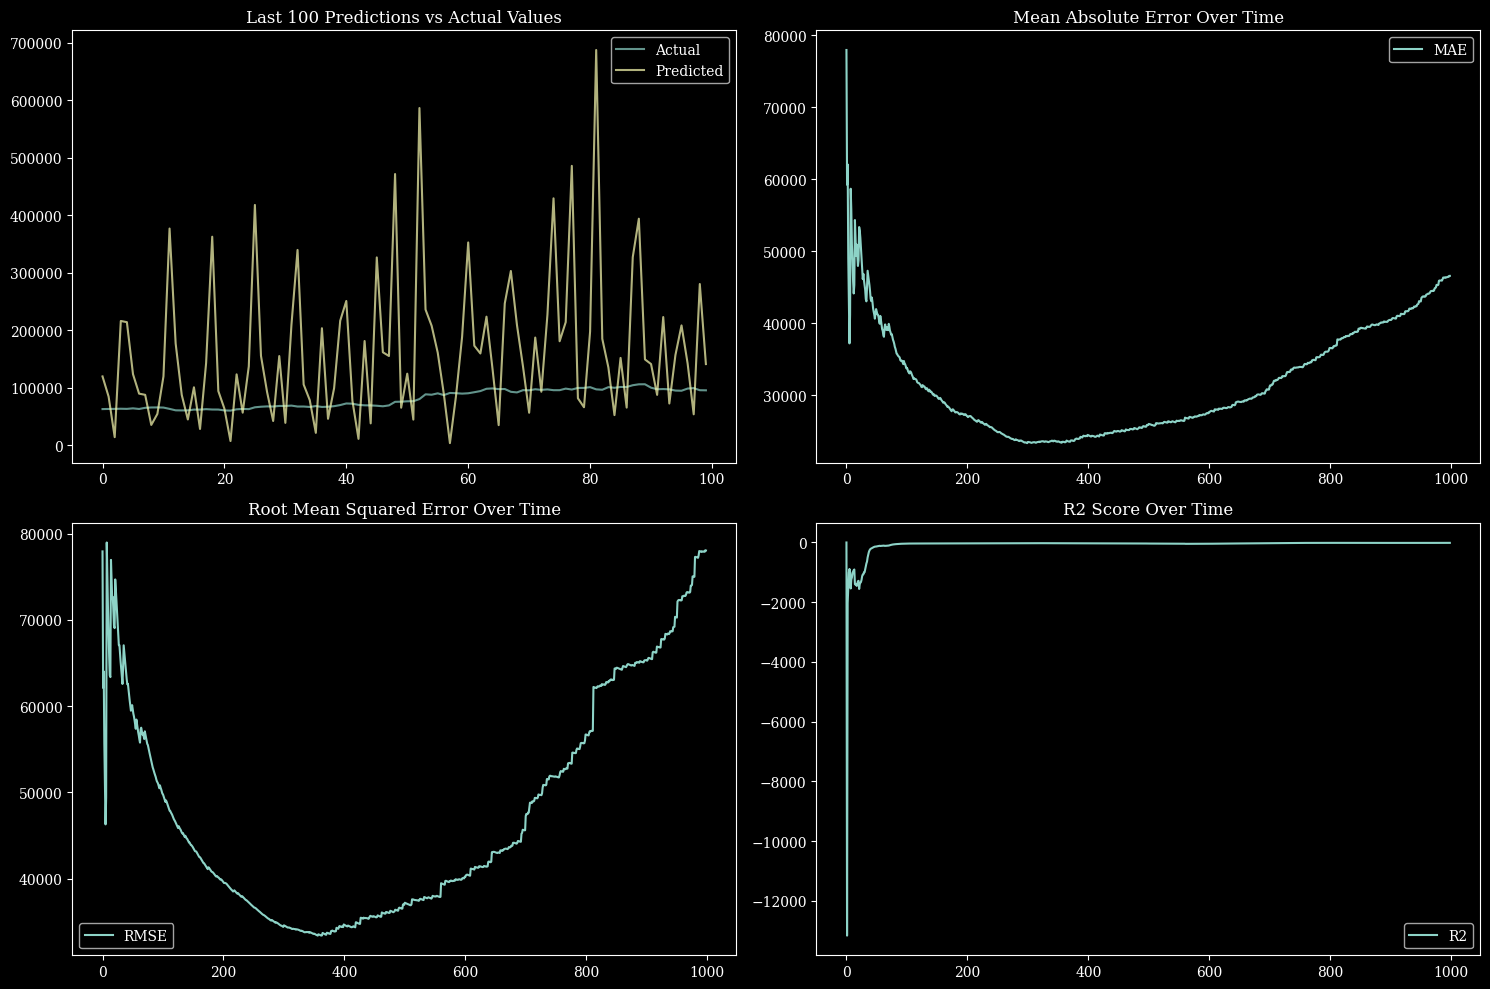


Final Metrics:
MAE: 46560.1200
RMSE: 78063.1233
R2: -12.2622

Prediction Statistics:
              Actual      Predicted
count     999.000000     999.000000
mean    40773.989219   77524.297460
std     21446.473317   78514.422992
min     15781.290000     141.594667
25%     23536.285000   30722.538883
50%     30289.520000   52999.964060
75%     60642.650000   96125.017162
max    106133.740000  764781.891481

Directional Accuracy: 53.51%


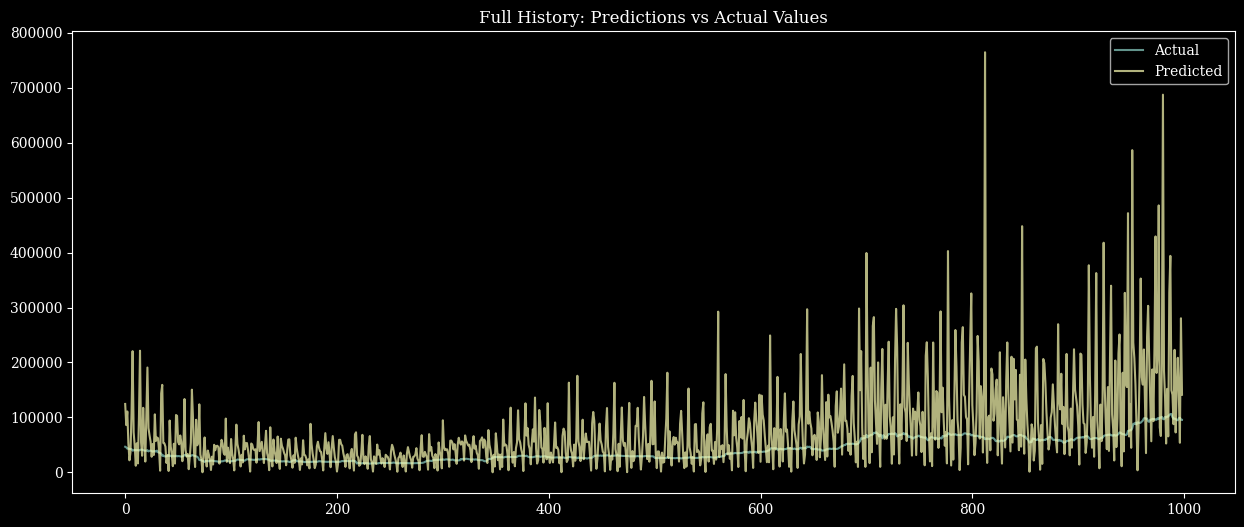

In [11]:
def prepare_data(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Ensure datetime columns are in the correct format
    df['start_time'] = pd.to_datetime(df['date']).dt.strftime('%d-%m-%Y %H:%M:%S')
    df['end_time'] = (pd.to_datetime(df['date']) + pd.Timedelta(minutes=1)).dt.strftime('%d-%m-%Y %H:%M:%S')
    
    return df

# Initialize model and metrics storage
model = linear_model.PARegressor()

predictions = []
actual_values = []

# Load your data
csv_path = './data/BL_data_BTCUSDT.csv'  # Your CSV path
df = prepare_data(csv_path)

# Initialize metric trackers
mae_metric = metrics.MAE()
rmse_metric = metrics.RMSE()
r2_metric = metrics.R2()

mae_history = []
rmse_history = []
r2_history = []

# Simulate online learning and prediction
for idx, row in df.iterrows():
    # Prepare features
    X_new = {
        'open': float(row['open']),
        'high': float(row['high']),
        'low': float(row['low']),
        'volume': float(row['volume']),
        # Add some basic technical features
        'high_low_diff': float(row['high']) - float(row['low']),
        'open_close_diff': float(row['close']) - float(row['open']),
        'volume_price': float(row['volume']) * float(row['close'])
    }
    
    y_new = float(row['close'])
    
    # Make prediction before learning (to simulate real-time prediction)
    if idx > 0:  # Start predicting from the second instance
        pred = model.predict_one(X_new)
        predictions.append(pred)
        actual_values.append(y_new)
        
        # Update metrics
        mae_metric.update(y_new, pred)
        rmse_metric.update(y_new, pred)
        r2_metric.update(y_new, pred)
        
        # Store metrics history
        mae_history.append(mae_metric.get())
        rmse_history.append(rmse_metric.get())
        r2_history.append(r2_metric.get())
    
    # Learn from current instance
    model.learn_one(X_new, y_new)
    
    # Print progress every 100 instances
    if idx % 100 == 0:
        print(f"Processed {idx} instances...")

# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Predictions vs Actual Values
plt.subplot(2, 2, 1)
plt.plot(actual_values[-100:], label='Actual', alpha=0.7)
plt.plot(predictions[-100:], label='Predicted', alpha=0.7)
plt.title('Last 100 Predictions vs Actual Values')
plt.legend()

# Plot 2: MAE History
plt.subplot(2, 2, 2)
plt.plot(mae_history, label='MAE')
plt.title('Mean Absolute Error Over Time')
plt.legend()

# Plot 3: RMSE History
plt.subplot(2, 2, 3)
plt.plot(rmse_history, label='RMSE')
plt.title('Root Mean Squared Error Over Time')
plt.legend()

# Plot 4: R2 History
plt.subplot(2, 2, 4)
plt.plot(r2_history, label='R2')
plt.title('R2 Score Over Time')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate final metrics
final_mae = mean_absolute_error(actual_values, predictions)
final_rmse = np.sqrt(mean_squared_error(actual_values, predictions))
final_r2 = r2_score(actual_values, predictions)

print("\nFinal Metrics:")
print(f"MAE: {final_mae:.4f}")
print(f"RMSE: {final_rmse:.4f}")
print(f"R2: {final_r2:.4f}")

# Calculate prediction statistics
prediction_stats = pd.DataFrame({
    'Actual': actual_values,
    'Predicted': predictions
})

print("\nPrediction Statistics:")
print(prediction_stats.describe())

# Calculate directional accuracy
correct_direction = sum(
    (actual_values[i] - actual_values[i-1]) * (predictions[i] - predictions[i-1]) > 0 
    for i in range(1, len(actual_values))
)
directional_accuracy = correct_direction / (len(actual_values) - 1)

print(f"\nDirectional Accuracy: {directional_accuracy:.2%}")

# Additional plot: Full prediction history
plt.figure(figsize=(15, 6))
plt.plot(actual_values, label='Actual', alpha=0.7)
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title('Full History: Predictions vs Actual Values')
plt.legend()
plt.show()

In [5]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Create toy data
np.random.seed(42)
timestamps = pd.date_range(start='2022-01-01', periods=100, freq='D')
pred_model1 = np.cumsum(np.random.randn(100)) + 10
pred_model2 = np.cumsum(np.random.randn(100)) + 20
pred_model3 = np.cumsum(np.random.randn(100)) + 30
pred_model4 = np.cumsum(np.random.randn(100)) + 40

data = pd.DataFrame({
    'timestamp': timestamps,
    'pred_model1': pred_model1,
    'pred_model2': pred_model2,
    'pred_model3': pred_model3,
    'pred_model4': pred_model4,
})

models = ['model1', 'model2', 'model3', 'model4']
base_colors = ['rgba(0, 0, 255, {})', 'rgba(255, 0, 0, {})', 'rgba(0, 128, 0, {})', 'rgba(128, 0, 128, {})']

# Create the plot
fig = go.Figure()

# Define opacity levels for gradient effect
opacity_levels = [0.2, 0.15, 0.1, 0.05]

for i, model in enumerate(models):
    # Add multiple layers with decreasing opacity for gradient effect
    for opacity in opacity_levels:
        fig.add_trace(go.Scatter(
            x=data['timestamp'],
            y=data[f'pred_{model}'],
            name=f'Model {model} Prediction' if opacity == opacity_levels[0] else None,  # Only label the first layer
            line=dict(color='rgba(0,0,0,0)'),
            fill='tonexty',
            fillcolor=base_colors[i % len(base_colors)].format(opacity),
            showlegend=opacity == opacity_levels[0]  # Only show legend for the first layer
        ))
    # Add the actual line on top of the gradient layers
    fig.add_trace(go.Scatter(
        x=data['timestamp'],
        y=data[f'pred_{model}'],
        name=f'Model {model} Prediction',
        line=dict(color=base_colors[i % len(base_colors)].format(0.8)),
    ))

# Update layout
fig.update_layout(
    title='Gradient Fill Between Curves and X-axis',
    xaxis_title='Timestamp',
    yaxis_title='Prediction',
    showlegend=True
)

fig.show()
